# Analysis, Spin-Spin Fitting, Decoherence

In [39]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from timedependent_channels import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=5, suppress=True)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Fit CNOT, Decoherence

In [40]:
model1 = loader("data/" + "spin-spin_cnot_gamma0_5.model")
channel1 = model1.channel

model2 = loader("data/" + "spin-spin_cnot_gamma1_0.model")
channel2 = model2.channel

model3 = loader("data/" + "spin-spin_cnot_gamma1_5.model")
channel3 = model3.channel

model4 = loader("data/" + "spin-spin_cnot_gamma2_0.model")
channel4 = model4.channel

model_ref = loader("data/" + "spin-spin_cnot_degreeTwo.model")

U = tf.convert_to_tensor([[1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 0, 1],
                            [0, 0, 1, 0]], dtype=tf.complex128)

channel_target = ChoiMapStatic(U, mode="unitary")

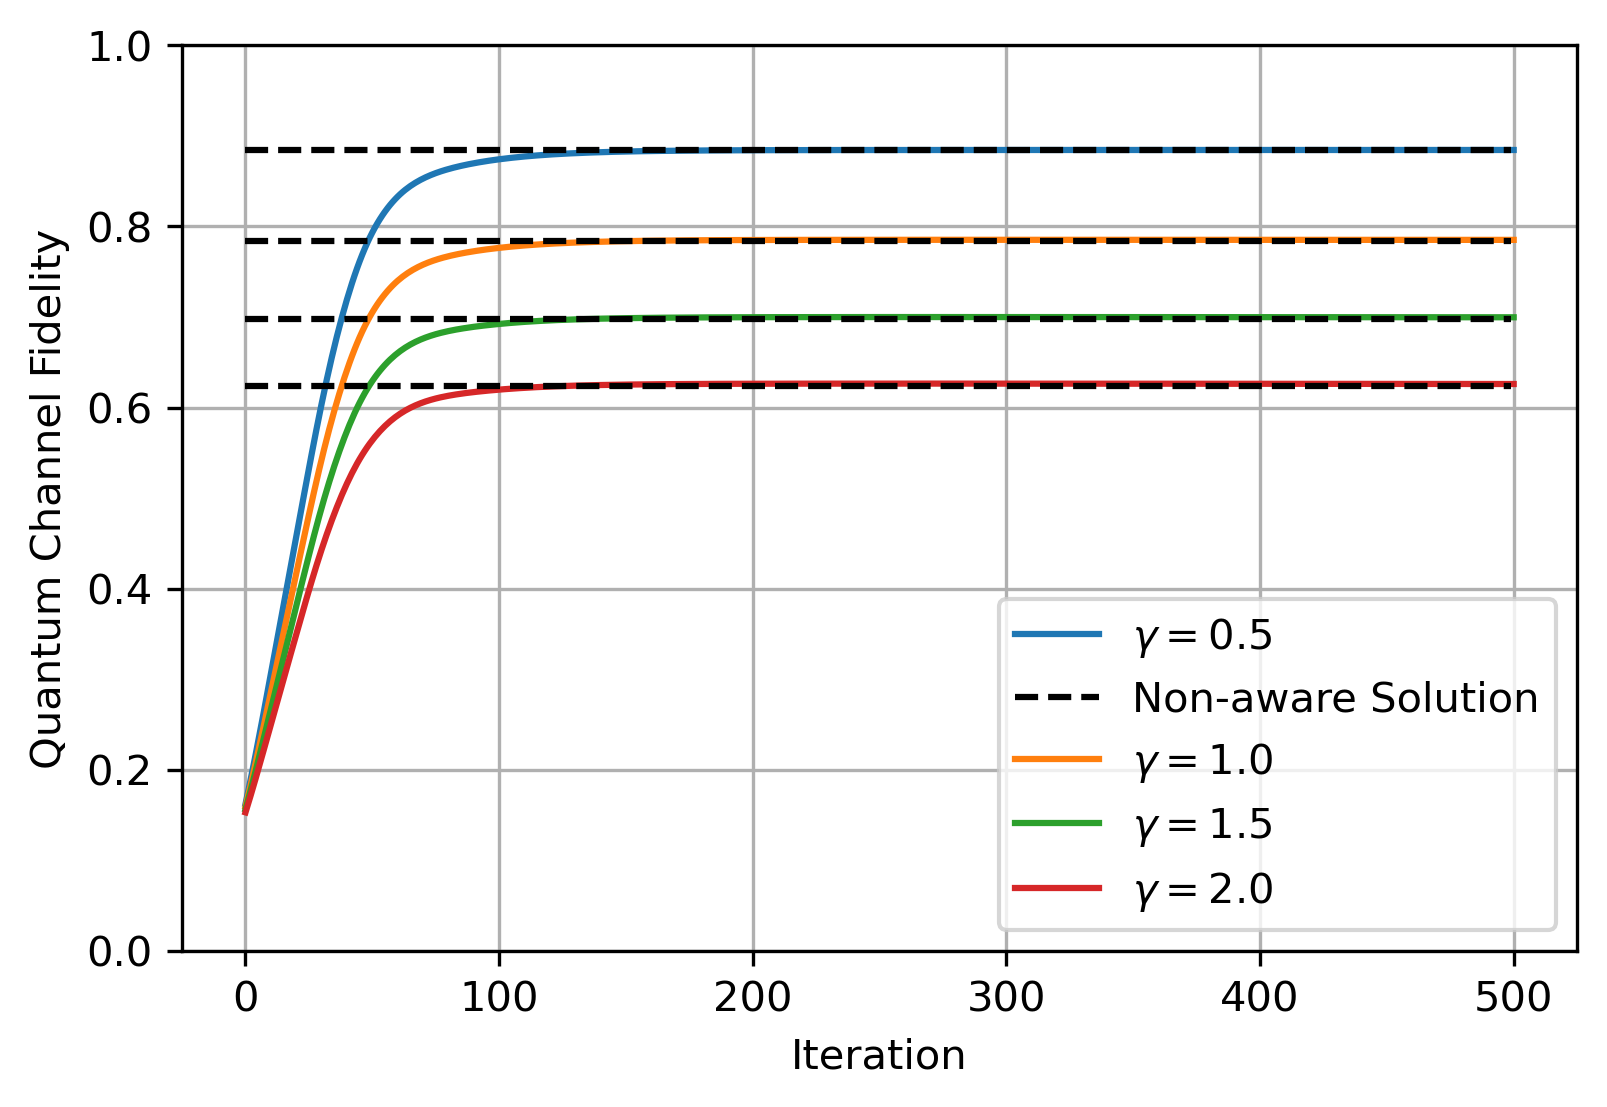

In [41]:
channel_ref = model_ref.channel
channel_ref.liouvillian.gamma = 0.5
val1 = channel_fidelity(channel_ref, channel_target)

channel_ref.liouvillian.gamma = 1.
val2 = channel_fidelity(channel_ref, channel_target)

channel_ref.liouvillian.gamma = 1.5
val3 = channel_fidelity(channel_ref, channel_target)

channel_ref.liouvillian.gamma = 2
val4 = channel_fidelity(channel_ref, channel_target)


fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(-np.array(model1.logger.loss_train_list), label="$\gamma = 0.5$")
plt.plot([0,499], [val1,val1], "--k", label="Non-aware Solution")



plt.plot(-np.array(model2.logger.loss_train_list), label="$\gamma = 1.0$")
plt.plot([0,499], [val2,val2], "--k")

plt.plot(-np.array(model3.logger.loss_train_list), label="$\gamma = 1.5$")
plt.plot([0,499], [val3,val3], "--k")

plt.plot(-np.array(model4.logger.loss_train_list), label="$\gamma = 2.0$")
plt.plot([0,499], [val4,val4], "--k")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Quantum Channel Fidelity")
plt.savefig("figures/" + "cnot_mitigation.pdf", bbox_inches='tight')
plt.show()

In [42]:
U = tf.convert_to_tensor([[1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 0, 1],
                            [0, 0, 1, 0]], dtype=tf.complex128)

channel_target = ChoiMapStatic(U, mode="unitary")

model_reference = loader("data/" + "spin-spin_cnot_degreeTwo.model")
channel_referece = model_reference.channel

In [43]:
channel_referece.liouvillian.gamma = 0.5
fidelity1 = channel_fidelity(channel1, channel_target)
fidelity_ref1 = channel_fidelity(channel_referece, channel_target)

channel_referece.liouvillian.gamma = 1.0
fidelity2 = channel_fidelity(channel2, channel_target)
fidelity_ref2 = channel_fidelity(channel_referece, channel_target)

channel_referece.liouvillian.gamma = 1.5
fidelity3 = channel_fidelity(channel3, channel_target)
fidelity_ref3 = channel_fidelity(channel_referece, channel_target)

channel_referece.liouvillian.gamma = 2.0
fidelity4 = channel_fidelity(channel4, channel_target)
fidelity_ref4 = channel_fidelity(channel_referece, channel_target)

In [44]:
print(fidelity1, fidelity_ref1)
print(fidelity2, fidelity_ref2)
print(fidelity3, fidelity_ref3)
print(fidelity4, fidelity_ref4)

tf.Tensor(0.8843075473154122, shape=(), dtype=float64) tf.Tensor(0.8840478647237169, shape=(), dtype=float64)
tf.Tensor(0.7850835045901771, shape=(), dtype=float64) tf.Tensor(0.7842871651085599, shape=(), dtype=float64)
tf.Tensor(0.6996539311745741, shape=(), dtype=float64) tf.Tensor(0.6982234747696155, shape=(), dtype=float64)
tf.Tensor(0.6260003625152449, shape=(), dtype=float64) tf.Tensor(0.6237763262251234, shape=(), dtype=float64)


## Teacher-Student Fitting, Decoherence

In [45]:
model1 = loader("data/" + "spin-spin_teacherStudent_gamma0_5.model")
channel1 = model1.channel

model2 = loader("data/" + "spin-spin_teacherStudent_gamma1_0.model")
channel2 = model2.channel

model3 = loader("data/" + "spin-spin_teacherStudent_gamma1_5.model")
channel3 = model3.channel

model4 = loader("data/" + "spin-spin_teacherStudent_gamma2_0.model")
channel4 = model4.channel

model_reference = loader("data/" + "spin-spin_teacherStudent.model")
channel_referece = model_reference.channel
channel_target = deepcopy(channel_referece)

In [35]:
channel_referece.liouvillian.gamma = 0.5
fidelity1 = channel_fidelity(channel1, channel_target)
fidelity_ref1 = channel_fidelity(channel_referece, channel_target)

channel_referece.liouvillian.gamma = 1.0
fidelity2 = channel_fidelity(channel2, channel_target)
fidelity_ref2 = channel_fidelity(channel_referece, channel_target)

channel_referece.liouvillian.gamma = 1.5
fidelity3 = channel_fidelity(channel3, channel_target)
fidelity_ref3 = channel_fidelity(channel_referece, channel_target)

channel_referece.liouvillian.gamma = 2.0
fidelity4 = channel_fidelity(channel4, channel_target)
fidelity_ref4 = channel_fidelity(channel_referece, channel_target)

In [36]:
print(fidelity1, fidelity_ref1)
print(fidelity2, fidelity_ref2)
print(fidelity3, fidelity_ref3)
print(fidelity4, fidelity_ref4)

tf.Tensor(0.8839258545784197, shape=(), dtype=float64) tf.Tensor(0.8839393359216695, shape=(), dtype=float64)
tf.Tensor(0.7837794122496367, shape=(), dtype=float64) tf.Tensor(0.7839443930407196, shape=(), dtype=float64)
tf.Tensor(0.6970570183325004, shape=(), dtype=float64) tf.Tensor(0.6976229645506583, shape=(), dtype=float64)
tf.Tensor(0.6215060828178898, shape=(), dtype=float64) tf.Tensor(0.622959990027435, shape=(), dtype=float64)


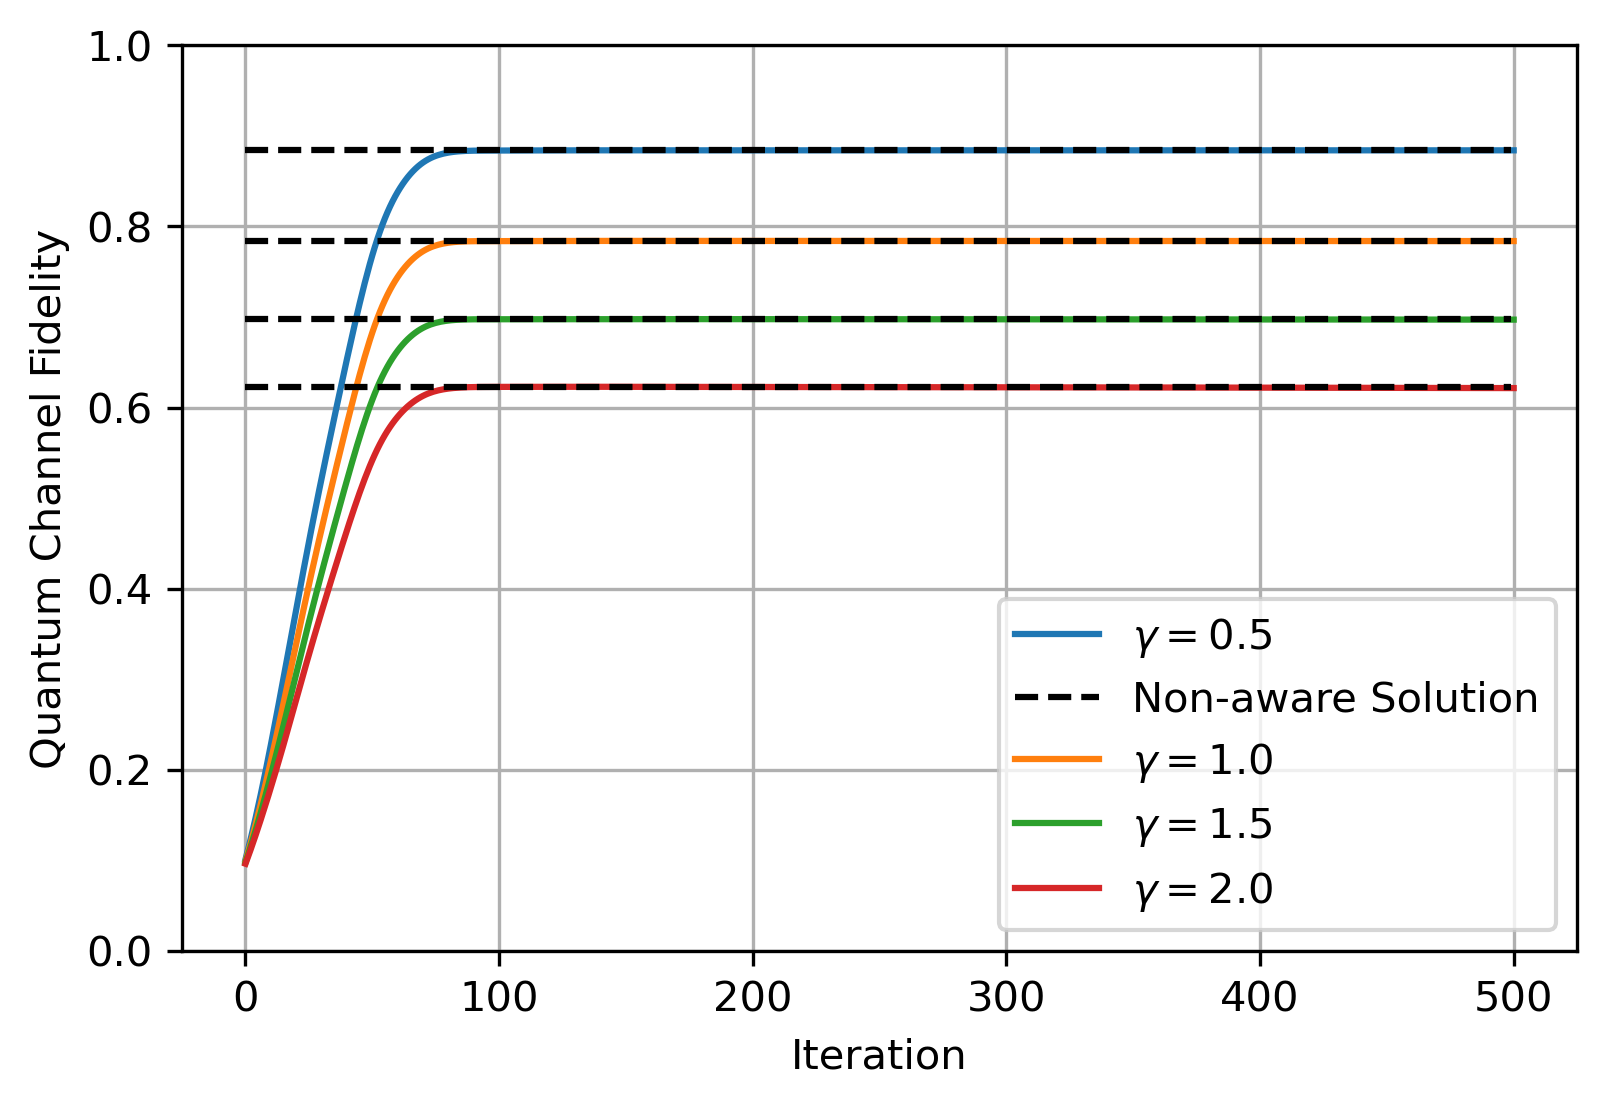

In [38]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.plot(-np.array(model1.logger.loss_train_list), label="$\gamma = 0.5$")
plt.plot([0,499], [fidelity_ref1,fidelity_ref1], "--k", label="Non-aware Solution")



plt.plot(-np.array(model2.logger.loss_train_list), label="$\gamma = 1.0$")
plt.plot([0,499], [fidelity_ref2,fidelity_ref2], "--k")

plt.plot(-np.array(model3.logger.loss_train_list), label="$\gamma = 1.5$")
plt.plot([0,499], [fidelity_ref3,fidelity_ref3], "--k")

plt.plot(-np.array(model4.logger.loss_train_list), label="$\gamma = 2.0$")
plt.plot([0,499], [fidelity_ref4,fidelity_ref4], "--k")
plt.ylim(0, 1)
plt.grid()
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Quantum Channel Fidelity")
plt.savefig("figures/" + "cnot_teacher_student.pdf", bbox_inches='tight')
plt.show()